## **Door Opening**

In [1]:
import numpy as np
from pydrake.examples.manipulation_station import ManipulationStation

from pydrake.all import (
    DiagramBuilder, MeshcatVisualizerCpp, MeshcatVisualizerParams, 
    Simulator, FindResourceOrThrow,
    Parser, MultibodyPlant, RigidTransform, RollPitchYaw,
    PiecewisePolynomial, PiecewiseQuaternionSlerp, RotationMatrix, Solve,
    TrajectorySource, ConstantVectorSource
)
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial
from manipulation.meshcat_cpp_utils import (
  StartMeshcat, AddMeshcatTriad
)
from manipulation.scenarios import AddMultibodyTriad


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

In [3]:
def setup_manipulation_station():
  builder = DiagramBuilder()
  station = builder.AddSystem(ManipulationStation(time_step=1e-3))
  station.SetupManipulationClassStation()
  
  AddMultibodyTriad(
      station.get_multibody_plant().GetFrameByName("body"), station.get_scene_graph())
  station.Finalize()

  MeshcatVisualizerCpp.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False))

  wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
  builder.Connect(wsg_position.get_output_port(),
                  station.GetInputPort("wsg_position"))

  diagram = builder.Build()

  plant = station.get_multibody_plant()
  context = plant.CreateDefaultContext()
  gripper = plant.GetBodyByName("body")

  initial_pose = plant.EvalBodyPoseInWorld(context, gripper)

  simulator = Simulator(diagram)
  simulator.set_target_realtime_rate(1.0)
  simulator.AdvanceTo(0.01)

  return initial_pose

# Get initial pose of the gripper by using default context of manip station.
initial_pose = setup_manipulation_station()

p_WR = np.array([0.7477, -0.1445, 0.4148]) # frame R: center of left door.

p_Rhandle = np.array([-0.033, 0.1245, 0]) # handle: frame attached to right handle.
p_Whandle = p_WR + p_Rhandle

p_Rhinge = np.array([0.008, -0.1395, 0]) # hinge: frame attached to right hinge.
p_Whinge = p_WR + p_Rhinge

p_Rhinge_handle = p_Rhandle - p_Rhinge
r_Rhinge_handle = np.linalg.norm(p_Rhandle - p_Rhinge) # distance between handle and hinge.

theta_Rhinge_handle = np.arctan2(p_Rhinge_handle[1], p_Rhinge_handle[0])
angle_end = np.pi # end of angle. Decrease to 120~160 deg for the easy version.

# Interpolate pose for opening doors.
def InterpolatePoseOpen(t):
  # Start by interpolating the yaw angle of the hinge.
  angle_start = theta_Rhinge_handle
  theta = angle_start + (angle_end - angle_start) * t
  # Convert to position and rotation.
  p_Whandle = r_Rhinge_handle * np.array([np.cos(theta), np.sin(theta), 0]) + p_Whinge
  # Add some offset here to account for gripper yaw angle.
  R_Whandle = RollPitchYaw(0, 0, theta).ToRotationMatrix()
  X_Whandle = RigidTransform(R_Whandle, p_Whandle)

  # Add a little offset to account for gripper.
  p_handleG = np.array([0., 0.1, 0.])
  R_handleG = RollPitchYaw(0, np.pi, np.pi).ToRotationMatrix()
  X_handleG = RigidTransform(R_handleG, p_handleG)
  X_WG = X_Whandle.multiply(X_handleG)
  return X_WG

## Interpolate Pose for entry.
def make_gripper_orientation_trajectory():
  traj = PiecewiseQuaternionSlerp()
  traj.Append(0.0, initial_pose.rotation())
  traj.Append(5.0, InterpolatePoseOpen(0.0).rotation())
  return traj

def make_gripper_position_trajectory():
  traj = PiecewisePolynomial.FirstOrderHold(
      [0.0, 5.0],
      np.vstack([[initial_pose.translation()],
                 [InterpolatePoseOpen(0.0).translation()]]).T)
  return traj

entry_traj_rotation = make_gripper_orientation_trajectory()
entry_traj_translation = make_gripper_position_trajectory()

def InterpolatePoseEntry(t):
  return RigidTransform(RotationMatrix(entry_traj_rotation.value(t)),
                        entry_traj_translation.value(t))

# Wrapper function for end-effector pose. Total time: 11 seconds.
def InterpolatePose(t):
  if (t < 5.0):
    # Duration of entry motion is set to 5 seconds.
    return InterpolatePoseEntry(t)
  elif (t >= 5.0) and (t < 6.0):
    # Wait for a second to grip the handle.
    return InterpolatePoseEntry(5.0)
  else:
    # Duration of the open motion is set to 5 seconds.
    return InterpolatePoseOpen((t - 6.0) / 5.0)

# Visualize our end-effector nominal trajectory.
t_lst = np.linspace(0, 11, 30)
pose_lst = []
for t in t_lst:
  AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePose(t), opacity=.2)
  pose_lst.append(InterpolatePose(t))

# Create gripper trajectory.
gripper_t_lst = np.array([0., 5., 6., 11.])
gripper_knots = np.array([0.05, 0.05, 0., 0.]).reshape(1,4)
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    robot_sdf_path = FindResourceOrThrow(
        "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
    gripper_sdf_path = FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    parser = Parser(plant=plant_robot)
    parser.AddModelFromFile(robot_sdf_path)
    parser.AddModelFromFile(gripper_sdf_path)
    plant_robot.WeldFrames(
        frame_on_parent_P=plant_robot.world_frame(),
        frame_on_child_C=plant_robot.GetFrameByName("iiwa_link_0"))
    plant_robot.WeldFrames(
        frame_on_parent_P=plant_robot.GetFrameByName("iiwa_link_7"),
        frame_on_child_C=plant_robot.GetFrameByName("body"),
        X_PC=RigidTransform(RollPitchYaw(np.pi/2, 0, np.pi/2), np.array([0, 0, 0.114]))
    )
    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index())

    return plant_robot, link_frame_indices

def BuildAndSimulateTrajectory(q_traj, g_traj):
  """Simulate trajectory for manipulation station.
  @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
  @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
  """
  builder = DiagramBuilder()
  station = builder.AddSystem(ManipulationStation(time_step=1e-3))
  station.SetupManipulationClassStation()
  AddMultibodyTriad(
      station.get_multibody_plant().GetFrameByName("body"), station.get_scene_graph())
  station.Finalize()

  q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
  g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

  MeshcatVisualizerCpp.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False))

  builder.Connect(q_traj_system.get_output_port(),
                  station.GetInputPort("iiwa_position"))
  builder.Connect(g_traj_system.get_output_port(),
                  station.GetInputPort("wsg_position"))

  diagram = builder.Build()
  display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

  simulator = Simulator(diagram)
  simulator.set_target_realtime_rate(1.0)
  simulator.AdvanceTo(0.01)

  station_plant = station.get_multibody_plant()

  return simulator, station_plant

## Door Opening

In the lecture, we've seen an example of a robot manipulating a cylindrical object in the DARPA Robotics Challenge. By using a similar optimization-based inverse kinematics, We will solve a series of IK problems that can open a cupboard door.

If you open up Meshcat at the link you got by running the first cell, you should be able to see that we provided you with setpoints ${}^W X^G(t)$ in the end-effector space, which gives us a nominal trajectory to reach and open the cupboard, which was computed by dividing the motion into following segments:

- $0 \leq t \leq 5$: The end-effector linearly interpolates between the initial pose at $t=0$, and the nominal grasp pose required to grip the cylinder (${}^W\mathbf{X}^H$ at $t=5$), while having the gripper open.
- $5 \leq t \leq 6$: The end-effector stays still at ${}^W\mathbf{X}^H$, and the gripper is closed.
- $6 \leq t \leq 11$: The end-effector follows an arc of the handle as the door opens. The gripper remains closed.

Your job is to convert this end effector trajectory to a joint-space trajectory using optimization!



## Writing down the Optimization Problem

Before we code, let's think about what we want from this optimization problem by observing the below diagram. We will denote our decision variables as $q$ (joint angles of the arm), and the forward dynamics function as

$${}^W\mathbf{X}^G = f(q)$$

(You may access the rotation and translation parts independently with ${}^W\mathbf{R}^G=f_R(q)$ and ${}^Wp^G=f_p(q)$). As written above, $H$ is the nominal frame which we've defined at the center of the handle.

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/figures/exercises/door.png" width="700">

Recall one of the main ideas from the lecture: instead of having ${}^W\mathbf{X}^G=f(q)$ be constrained to exactly ${}^W\mathbf{X}^H$, the inverse kinematics problem can benefit a lot by allowing a set of ${}^W\mathbf{X}^G$ which makes sense for our problem.





**Problem 8.1.a** [3pts]: Let us parametrize ${}^H X ^G$ with six degrees of freedom: xyz positions and roll-pitch-yaw rotation (i.e. rotations around the xyz axii, respectively) of frame $G$ with respect to frame $H$. Which three would you constrain to be exactly equal, and which three are you willing to provide some slack? Explain your reasoning.

(HINT: you should constrain two positions and one orientation).

**Problem 8.1.b** [2pts]: Write down an optimization problem to find $q$ with a joint centering cost on $q_{nom}$, and the constraints you wrote down in 8.1.a. You should write a equality constraint for the constrained degrees of freedom, and inequality constraints for the unconstrained one. Writing a constraint on some principal axis of orientation is fairly involved due to rotation formalisms, so in this problem you may full constrain the orientation degrees of freedom (i.e. using equality constraints).

(HINT: The grading will allow some abuse of notation. For example, you can write down x component of $f_p(q)$ with $f_p(q)_x$, $f_p(q)[0]$, etc. But please be clear in what you intend and you should not be sloppy with frames).

## Solving Optimization

**Now, it's your time to code!**

Below, you must implement `create_q_knots`, which accepts a list of key frames `pose_lst`, and converts them to joint coordinates. You will use Drake's `inverse_kinematics` package, for which we've provided simple wrappers called `AddOrientationConstraint` and `AddPositionConstraint`.

For each keyframe `i`, our solution does the following:
- Implement constraints on `ik` using `AddOrientationConstraint` and `AddPositionConstraint`. Note that for this subpart, AddOrientationConstraint implements an inequality constraint (see the docstring for more information).
- Add a joint-centering cost on `q_nominal`.
- If `i==0`, Set initial guess to be nominal configuration using [`prog.SetInitialGuess`](https://drake.mit.edu/pydrake/pydrake.solvers.mathematicalprogram.html#pydrake.solvers.mathematicalprogram.MathematicalProgram.SetInitialGuess). Otherwise, set the initial guess to be the solution you obtained on the previous IK problem.

We will grade your solution by how far you were able to pull the door!


In [4]:
handle_length = 0.05 # Door handle length
angle_bounds = 0.2

def create_q_knots(pose_lst):
  """Convert end-effector pose list to joint position list using series of
  InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
  contain gripper joints, but these should not matter to the constraints.
  @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
  @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
  """
  q_knots = []
  plant, _ = CreateIiwaControllerPlant()
  world_frame = plant.world_frame()
  gripper_frame = plant.GetFrameByName("body")
  q_nominal = np.array([ 0., 0.6, 0., -1.75, 0., 1., 0., 0., 0.]) # nominal joint for joint-centering.

  def AddOrientationConstraint(ik, R_WG, bounds):
    """Add orientation constraint to the ik problem. Implements an inequality
    constraint where the axis-angle difference between f_R(q) and R_WG must be
    within bounds. Can be translated to:
    ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
    """
    ik.AddOrientationConstraint(
        frameAbar=world_frame, R_AbarA=R_WG,
        frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
        theta_bound=bounds
    )

  def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
    """Add position constraint to the ik problem. Implements an inequality
    constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
    translated to
    ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
    """
    ik.AddPositionConstraint(
        frameA=world_frame, frameB=gripper_frame, p_BQ=np.zeros(3),
        p_AQ_lower=p_WG_lower, p_AQ_upper=p_WG_upper)

  for i in range(len(pose_lst)):
    ik = inverse_kinematics.InverseKinematics(plant)
    q_variables = ik.q() # Get variables for MathematicalProgram
    prog = ik.prog() # Get MathematicalProgram

    #### Modify here ###############################
    if i == 0:
      prog.SetInitialGuess(q_variables, q_nominal)
    else:
      prog.SetInitialGuess(q_variables, q_knots[-1])

    p_WG_lower = pose_lst[i].translation() - np.array([0,0,handle_length/2])
    p_WG_upper = pose_lst[i].translation() + np.array([0,0,handle_length/2])
        
    AddPositionConstraint(ik, p_WG_lower, p_WG_upper)
    AddOrientationConstraint(ik, pose_lst[i].rotation(), angle_bounds)

    ################################################
  
    result = Solve(prog)

    if not result.is_success():
      raise RuntimeError
      
    q_knots.append(result.GetSolution(q_variables))

  return q_knots

When you have implemented your function, you can run the cell below to initialize your simulation. Once everything loads up in Meshcat, run the next cell to run the full simulation!

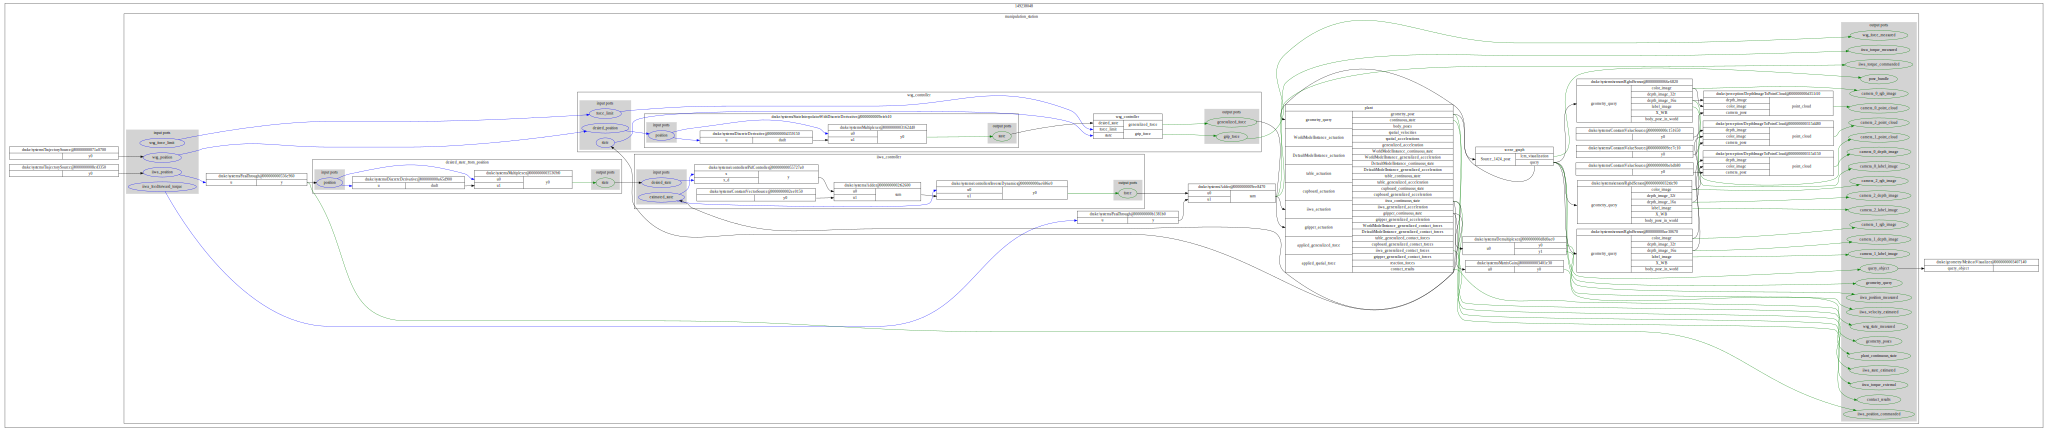

In [7]:
from IPython.display import display, SVG
import numpy as np
import ipywidgets
import pydot
import pydrake.all
import os
q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj)

In [ ]:
simulator.AdvanceTo(0.1)
# Uncomment and run the simulation to 11 seconds for results.
simulator.AdvanceTo(11.0)

# How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza.

For submission of this assignment, you must do two things.
- Download and submit the notebook `door_opening.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Write down your answers to 8.1.a to a separately pdf file and submit it to Gradescope's written submission section.

For the coding assignment, we will check the angle of the door at the end of the simulation. You will get points based on how far your implementation was able to open the door!
- [3 pts] 8.1.a is answered correctly.
- [2 pts] 8.1.b is answered correctly.
- [2 pts] The door angle is over 10 degrees.
- [2 pts] The door angle is over 40 degrees.
- [1 pts] The door angle is over 70 degrees.


In [ ]:
from manipulation.exercises.trajectories.test_door_opening import TestDoorOpening
from manipulation.exercises.grader import Grader

Grader.grade_output([TestDoorOpening], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 5/5.

Score for Test 40 degree bound for door angle is 2/2.

Score for Test 70 degree bound for door angle is 1/1.

Score for Test 10 degree bound for door angle is 2/2.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f5e55d5-2682-4fb7-b6bb-9431dd41276f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>